In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb

In [2]:
df_raw2= pd.read_csv('df_raw2_final.csv')

In [3]:
df_raw2.shape

(3563, 673)

In [4]:
df_raw2.index.values

array([   0,    1,    2, ..., 3560, 3561, 3562], dtype=int64)

In [5]:
TESTinds = np.random.choice(df_raw2.index.values, 360, replace = False) #randomly choose 360 data points and reserve as test

In [6]:
inds = np.setdiff1d(df_raw2.index.values, TESTinds)

In [3]:
# df_raw2_train=df_raw2.loc[inds]
# ##df_raw2.drop(columns=['id'], inplace=True)
# df=df_raw2_train


df= pd.read_csv('df_raw2_train.csv')

#df_raw2_train.to_csv("df_raw2_train.csv", index=False)
df.shape

(3203, 673)

In [4]:
cat_feats = ['actor_1_name','actor_2_name','actor_3_name','director_name']
#label encoded features as categorical features

# cat_feats2 = ['actor_1_name','actor_2_name','actor_3_name','director_name','title_year']


In [5]:
useless_cols = ["id","imdb_score"]

train_cols = df.columns[~df.columns.isin(useless_cols)]
X_train = df[train_cols]
y_train = df["imdb_score"]

In [6]:
fake_valid_inds = np.random.choice(X_train.index.values, 600, replace = False)

#fake_valid_inds = X_train.index.values[-698948:]
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)
train_data = lgb.Dataset(X_train.loc[train_inds] , label = y_train.loc[train_inds], 
                         categorical_feature=cat_feats, free_raw_data=False)
fake_valid_data = lgb.Dataset(X_train.loc[fake_valid_inds], label = y_train.loc[fake_valid_inds],
                              categorical_feature=cat_feats,
                 free_raw_data=False)

In [7]:
params = {
        "objective" : 'poisson',  
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,# 0.05, #
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
#         "nthread" : 4
        #'max_depth': 10,
        "metric": ["rmse"],
    'verbosity': 1,
    'num_iterations' : 1200*2,
    'num_leaves': 128,
    "min_data_in_leaf": 100,
}

In [8]:
%%time

m_lgb = lgb.train(params, train_data, valid_sets = [fake_valid_data], verbose_eval=20) 

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[20]	valid_0's rmse: 0.817184
[40]	valid_0's rmse: 0.756858
[60]	valid_0's rmse: 0.728604
[80]	valid_0's rmse: 0.710366
[100]	valid_0's rmse: 0.699656
[120]	valid_0's rmse: 0.69746
[140]	valid_0's rmse: 0.693896
[160]	valid_0's rmse: 0.692321
[180]	valid_0's rmse: 0.689862
[200]	valid_0's rmse: 0.689084
[220]	valid_0's rmse: 0.688212
[240]	valid_0's rmse: 0.687911
[260]	valid_0's rmse: 0.687541
[280]	valid_0's rmse: 0.68706
[300]	valid_0's rmse: 0.688657
[320]	valid_0's rmse: 0.689161
[340]	valid_0's rmse: 0.687881
[360]	valid_0's rmse: 0.687217
[380]	valid_0's rmse: 0.686968
[400]	valid_0's rmse: 0.687101
[420]	valid_0's rmse: 0.686686
[440]	valid_0's rmse: 0.686757
[460]	valid_0's rmse: 0.68614
[480]	valid_0's rmse: 0.686928
[500]	valid_0's rmse: 0.687061
[520]	valid_0's rmse: 0.687226
[540]	valid_0's rmse: 0.687666
[560]	valid_0's rmse: 0.688126
[580]	valid_0's rmse: 0.687876
[600]	valid_0's rmse: 0.688763
[620]	valid_0's rmse: 0.688639
[640]	valid_0's rmse: 0.68913
[660]	valid_0's 

In [17]:

df_raw2_test= df_raw2.loc[TESTinds]
df_raw2_test.shape
#df_raw2_test.to_csv("df_raw2_test.csv", index=False)
df_raw2_test.shape

(360, 673)

In [14]:

X_test=df_raw2_test[train_cols]
y_test=df_raw2_test["imdb_score"]
preds = m_lgb.predict(X_test)

In [15]:
# m_lgb.save_model("modelLGB.lgb")
import sklearn.metrics as metrics
import math
print('LightGBM - test rmse: ', math.sqrt(metrics.mean_squared_error(y_test, preds)))
#.7757107405777778

LightGBM - test rmse:  0.7757107405777778


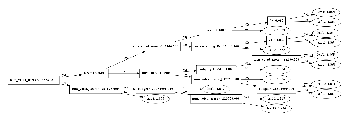

In [9]:
lgb.plot_tree(m_lgb)

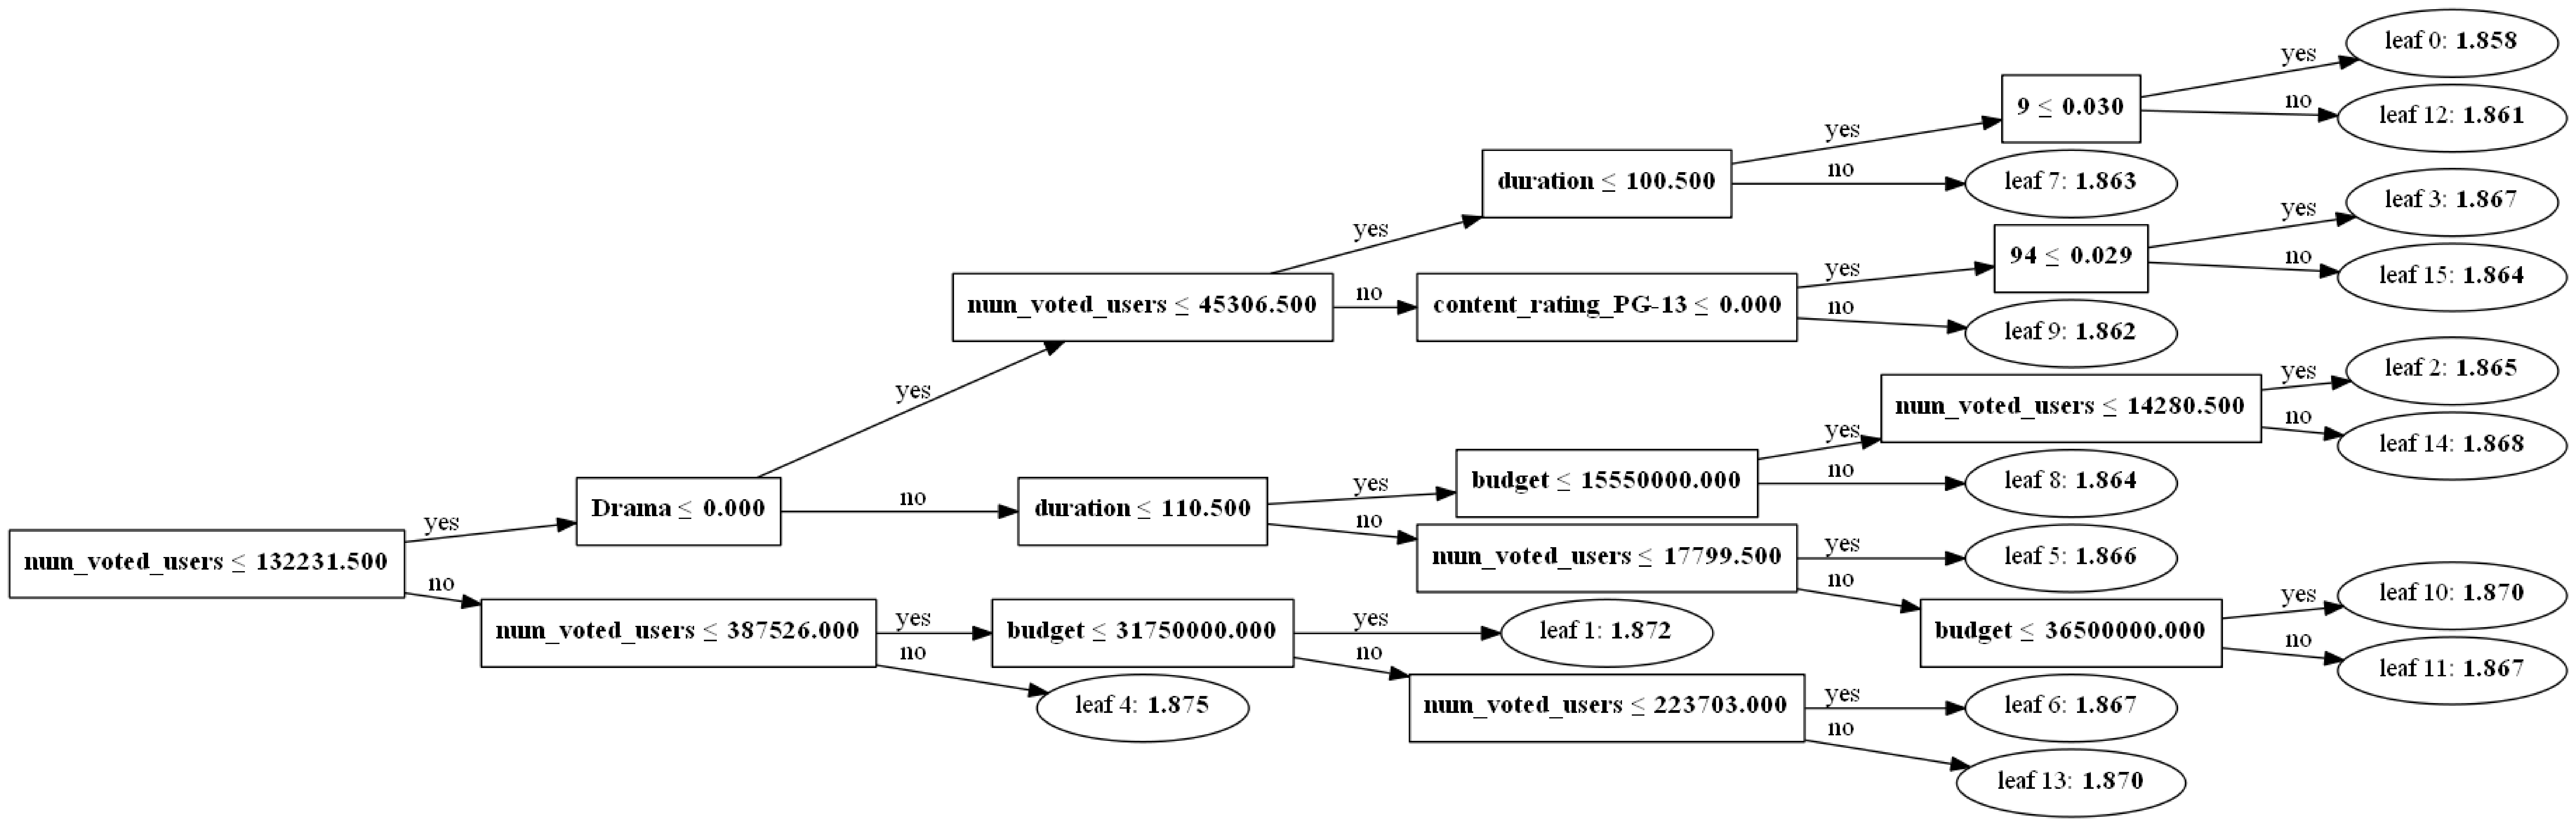

In [11]:
import matplotlib.pyplot as plt
lgb.plot_tree(m_lgb)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('LGBtree.png')